In [19]:
import pandas as pd

from src.constant import MAIN_DIR
from src.database import DB
from tqdm.auto import tqdm
import numpy as np

PHASE2_DIR = MAIN_DIR / "archive" / "phase2"
PHASE2_TRASH_DIR = MAIN_DIR / "archive" / "phase2_trash"

In [20]:
records = []
db_path_list = list(PHASE2_DIR.glob("run-policy-*.db"))
progress_bar = tqdm(total=len(db_path_list), desc="Processing")

for db_path in db_path_list:
    parts = db_path.stem.split("-")
    policy, parg, n_train = parts[2:5]
    progress_bar.set_description(f"{policy=}, {parg=}, {n_train=}") 

    db = DB(db_path)
    results = db.get_results()
    results_test = results.loc[results["prefix"].str.startswith("test")]
    # if results_test.shape[0] != 2500:
    if results_test.empty:
        print(f"No results {db_path}")
        continue
    cost = (
        results.loc[results["prefix"].str.startswith("test")]
        .groupby(["instance_id", "prefix"])["cost"]
        .min()  # min for every problem (of 2 solvers)
        .reset_index()
        .groupby("instance_id")["cost"]
        .median()  # median over 5 runs
    )
    if cost.max() >= 100:
        print(f"Test cut-off {db_path}")
    cost = cost.mean()  # total mean score
    cpu_time = (
        results.loc[
            results["prefix"].str.startswith("config")
            & results["cached"].eq(0)
            & results["surrogate"].eq(0),
            "time",
        ].sum()
        / 3600
    )
    surrogate_pct = results.loc[results["prefix"].str.startswith("config")].groupby(["solver_id", "instance_id"])["surrogate"].max().mean()
    real_pct = results.loc[results["prefix"].str.startswith("config")].groupby(["solver_id", "instance_id"])["surrogate"].min().eq(0).mean()
    records.append(
        {
            "db_path": db_path.parts[-1],
            "n_train": n_train,
            "policy": policy,
            "parg": parg,
            "cost": cost,
            "cpu_time": cpu_time,
            "surrogate_pct": surrogate_pct,
            "real_pct": real_pct,
        }
    )
    progress_bar.update(1)
progress_bar.close()

df = pd.DataFrame(records)
df

Processing:   0%|          | 0/588 [00:00<?, ?it/s]

No results C:\Users\zakrz\Documents\DataScience\praca magisterska\raw-algorithm-portfolios\archive\phase2\run-policy-ec-75-250-1017398.db


,db_path,n_train,policy,parg,cost,cpu_time,surrogate_pct,real_pct
0,run-policy-baseline--100-1016233.db,100,baseline,,0.10736,14.748363,0.00000,1.000000
1,run-policy-baseline--100-1016239.db,100,baseline,,0.11484,14.685052,0.00000,1.000000
2,run-policy-baseline--100-1016307.db,100,baseline,,0.16572,13.298055,0.00000,1.000000
3,run-policy-baseline--100-1016319.db,100,baseline,,0.18088,11.804989,0.00000,1.000000
4,run-policy-baseline--100-1016325.db,100,baseline,,0.15440,11.919893,0.00000,1.000000
...,...,...,...,...,...,...,...,...
582,run-policy-ib--25-1015027.db,25,ib,,0.19264,0.541641,0.97449,0.142857
583,run-policy-ib--25-1015033.db,25,ib,,0.20272,0.600577,0.97449,0.142857
584,run-policy-ib--25-1015039.db,25,ib,,0.37448,0.298791,0.97449,0.112245
585,run-policy-ib--250-1017133.db,250,ib,,0.20132,4.597326,0.97449,0.163265


In [21]:
df.pivot_table(index=["policy", "parg"], columns="n_train", values="cpu_time", aggfunc="count")

n_train        100  25  250
policy   parg              
baseline        20  20    2
ea       25     20  20    2
         50     20  20    2
         75     20  20    2
eb       25     20  20    2
         50     20  20    2
         75     20  20    2
ec       100    20  20    2
         50     20  20    2
         75     20  20    1
ia       1+1    20  20    2
         1+2    20  20    2
         2+1    20  20    2
ib              20  20    2

In [22]:
IDX = [
    ("baseline", ""),
    ("ea", "25"),
    ("ea", "50"),
    ("ea", "75"),
    ("eb", "75"),
    ("eb", "50"),
    ("eb", "25"),
    ("ec", "100"),
    ("ec", "75"),
    ("ec", "50"),
    ("ia", "1+2"),
    ("ia", "1+1"),
    ("ia", "2+1"),
    ("ib", ""),
]

def agg(x):
    df_agg = x.groupby(["policy", "parg"]).agg(
        cost=("cost", "mean"),
        cpu_time=("cpu_time", "mean"),
        surrogate_pct=("surrogate_pct", "mean"),
        real_pct=("real_pct", "mean"),
    )
    baseline_cost = df_agg.at[("baseline", ""), "cost"]
    baseline_cpu_time = df_agg.at[("baseline", ""), "cpu_time"]
    df_agg["cost_ratio_to_baseline"] = df_agg["cost"] / baseline_cost
    df_agg["cpu_time_ratio_to_baseline"] = df_agg["cpu_time"] / baseline_cpu_time
    df_agg["alpha"] = baseline_cost / df_agg["cost"]
    df_agg["beta"] = (baseline_cpu_time - df_agg["cpu_time"]) * 3600 / df_agg["cost"]
    df_agg["better_than_baseline_until"] = np.floor(df_agg["beta"] / (1 - df_agg["alpha"])) + 1
    df_agg.loc[df_agg["beta"] < 0, "better_than_baseline_until"] = np.nan

    df_agg = df_agg.round(4)
    df_agg = df_agg.loc[IDX, ["cost", "cost_ratio_to_baseline", "cpu_time", "cpu_time_ratio_to_baseline", "surrogate_pct", "real_pct", "alpha", "beta", "better_than_baseline_until"]]
    return df_agg

df25 = df.loc[df["n_train"] == "25"].copy()
df100 = df.loc[df["n_train"] == "100"].copy()
df250 = df.loc[df["n_train"] == "250"].copy()

df25_agg = agg(df25)
df100_agg = agg(df100)
df250_agg = agg(df250)

In [23]:
df250_agg

cost  cost_ratio_to_baseline  cpu_time  \
policy   parg                                             
baseline       0.1305                  1.0000   32.5598   
ea       25    0.1510                  1.1570   25.4011   
         50    0.1410                  1.0805   17.1525   
         75    0.1571                  1.2042    9.1521   
eb       75    0.1600                  1.2262   15.5160   
         50    0.1836                  1.4073    6.1098   
         25    0.2963                  2.2712    1.9907   
ec       100   0.1458                  1.1177   79.4199   
         75    0.1591                  1.2192   43.2544   
         50    0.1628                  1.2479   37.9124   
ia       1+2   0.1369                  1.0492   22.6303   
         1+1   0.1258                  0.9644   17.6779   
         2+1   0.1320                  1.0113   11.9970   
ib             0.1761                  1.3498    6.1573   

               cpu_time_ratio_to_baseline  surrogate_pct  real_pct   alpha  \
policy   parg                                                                
baseline                           1.0000         0.0000    1.0000  1.0000   
ea       25                        0.7801         0.2416    0.7607  0.8643   
         50                        0.5268         0.4861    0.5189  0.9255   
         75                        0.2811         0.7301    0.2775  0.8304   
eb       75                        0.4765         0.9745    0.7609  0.8155   
         50                        0.1876         0.9745    0.5217  0.7106   
         25                        0.0611         0.9745    0.2787  0.4403   
ec       100                       2.4392         0.9745    1.0000  0.8947   
         75                        1.3285         0.9745    1.0000  0.8202   
         50                        1.1644         0.9745    1.0000  0.8014   
ia       1+2                       0.6950         0.3265    0.6760  0.9531   
         1+1                       0.5429         0.4898    0.5153  1.0369   
         2+1                       0.3685         0.6531    0.3520  0.9888   
ib                                 0.1891         0.9745    0.2015  0.7409   

                       beta  better_than_baseline_until  
policy   parg                                            
baseline       0.000000e+00                         NaN  
ea       25    1.707145e+05                   1258353.0  
         50    3.934320e+05                   5282481.0  
         75    5.363268e+05                   3163201.0  
eb       75    3.834848e+05                   2078509.0  
         50    5.185698e+05                   1791867.0  
         25    3.713596e+05                    663504.0  
ec       100  -1.156722e+06                         NaN  
         75   -2.420217e+05                         NaN  
         50   -1.183491e+05                         NaN  
ia       1+2   2.611110e+05                   5567928.0  
         1+1   4.257373e+05                 -11546288.0  
         2+1   5.609735e+05                  50017609.0  
ib             5.396832e+05                   2082582.0

In [14]:
# df100_agg.to_excel("tmp.xlsx")

In [15]:
# df.loc[(df["policy"] == "ec") & (df["parg"] == "50") & (df["n_train"] == "100")].sort_values(by="cost")

In [16]:
# db = DB(PHASE2_DIR / "run-policy-ib--100-1016238.db")

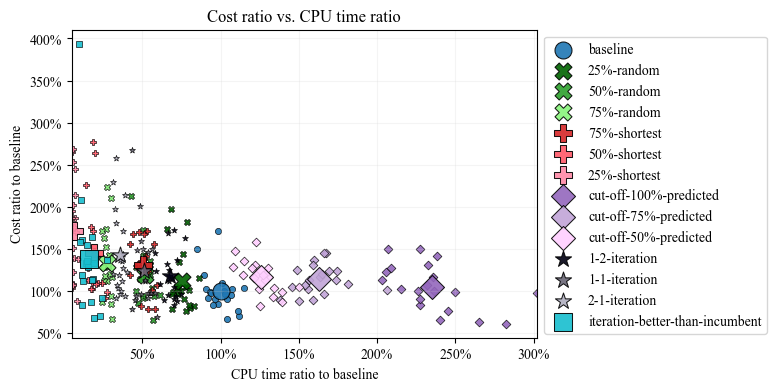

In [17]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.alpha"] = 0.2
plt.rcParams["grid.color"] = "#cccccc"
plt.rcParams["axes.xmargin"] = 0

COLORS = {
    ("baseline", ""): "#1f77b4",
    ("ea", "25"): "#006300",
    ("ea", "50"): "#2ca02c",
    ("ea", "75"): "#89f57b",
    ("eb", "75"): "#d62728",
    ("eb", "50"): "#ff5968",
    ("eb", "25"): "#ff8aa7",
    ("ec", "100"): "#9467bd",
    ("ec", "75"): "#c1a4d8",
    ("ec", "50"): "#ffcfff",
    ("ia", "1+2"): "#010013", 
    ("ia", "1+1"): "#696676",
    ("ia", "2+1"): "#b1afc0",
    ("ib", ""): "#17becf",
}

LABELS = {
    ("baseline", ""): "baseline",
    ("ea", "25"): "25%-random",
    ("ea", "50"): "50%-random",
    ("ea", "75"): "75%-random",
    ("eb", "75"): "75%-shortest",
    ("eb", "50"): "50%-shortest",
    ("eb", "25"): "25%-shortest",
    ("ec", "100"): "cut-off-100%-predicted",
    ("ec", "75"): "cut-off-75%-predicted",
    ("ec", "50"): "cut-off-50%-predicted",
    ("ia", "1+2"): "1-2-iteration", 
    ("ia", "1+1"): "1-1-iteration",
    ("ia", "2+1"): "2-1-iteration",
    ("ib", ""): "iteration-better-than-incumbent",
}

MARKERS = {
    "baseline": "o",
    "ea": "X",
    "eb": "P",
    "ec": "D",
    "ia": "*",
    "ib": "s",
}

def plot_cost_vs_cpu_time_ratio(df, df_agg, plot_all=False):
    fig, ax = plt.subplots(figsize=(6, 4))

    baseline_cost = df_agg.at[("baseline", ""), "cost"]
    baseline_cpu_time = df_agg.at[("baseline", ""), "cpu_time"]

    for (policy, parg), row in df_agg.iterrows():
        if plot_all:
            _ = df.loc[(df["policy"] == policy) & (df["parg"] == parg)]
            plt.scatter(
                _["cpu_time"] / baseline_cpu_time,
                _["cost"] / baseline_cost,
                s=20,
                alpha=0.9,
                color=COLORS[(policy, parg)],
                marker=MARKERS[policy],
                linewidths=0.5,
                edgecolor="black",
            )
        plt.scatter(
            row["cpu_time_ratio_to_baseline"],
            row["cost_ratio_to_baseline"],
            s=150,
            alpha=0.9,
            color=COLORS[(policy, parg)],
            marker=MARKERS[policy],
            linewidths=0.75,
            edgecolor="black",
            label=LABELS[(policy, parg)],
        )

    ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))

    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.xlabel("CPU time ratio to baseline")
    plt.ylabel("Cost ratio to baseline")
    if not plot_all:
        plt.xlim(0, 2.5)
        plt.ylim(0.9, 1.66)
    plt.title("Cost ratio vs. CPU time ratio")
    return fig, ax

# fig, ax = plot_cost_vs_cpu_time_ratio(df25, df25_agg, plot_all=True)
fig, ax = plot_cost_vs_cpu_time_ratio(df100, df100_agg, plot_all=True)
# plt.savefig("fig.png", dpi=300, bbox_inches="tight")
plt.show()

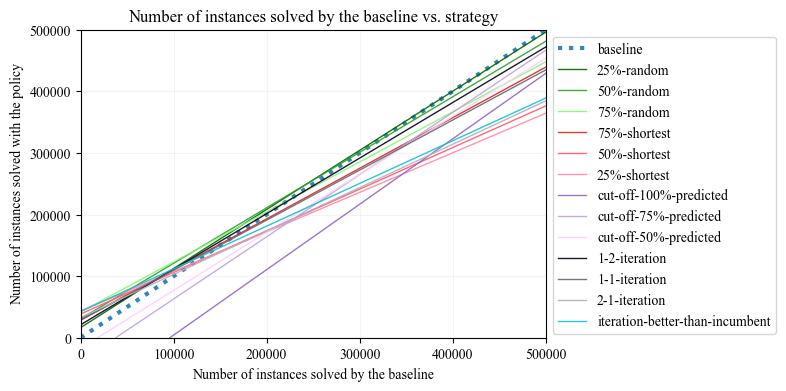

In [18]:
def plot_lines(df_agg, lim):
    fig, ax = plt.subplots(figsize=(6, 4))

    for (policy, parg), row in df_agg.iterrows():
        cost = row["cost"]
        cpu_time = row["cpu_time"]
        ax.axline(
            (0, row["beta"]),
            slope=row["alpha"],
            alpha=0.9,
            color=COLORS[(policy, parg)],
            lw=1 if policy != "baseline" else 3,
            ls="-" if policy != "baseline" else "dotted",
            label=LABELS[(policy, parg)],
        )

    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.xlabel("Number of instances solved by the baseline")
    plt.ylabel("Number of instances solved with the policy")
    plt.xlim(0, lim)
    plt.ylim(0, lim)
    plt.title("Number of instances solved by the baseline vs. strategy")
    return fig, ax

fig, ax = plot_lines(df25_agg, 500000)
# fig, ax = plot_lines(df100_agg, 1000000)
# plt.savefig("fig.png", dpi=300, bbox_inches="tight")
plt.show()